In [2]:
import numpy as np
import xgcm
from xgcm import Grid
from xhistogram.xarray import histogram
import xarray as xr
import xroms
from scipy import signal
import matplotlib.pyplot as plt
from glob import glob

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import pandas as pd
import seaborn as sns
sns.set_theme(style = 'whitegrid')

plt.rcParams.update({'font.size': 14})

from dask.distributed import Client

client = Client()
client

/home/dylan/.conda/envs/copanoenv/lib/python3.8/site-packages/distributed/client.py:1136: VersionMismatchWarning: Mismatched versions found

+-------------+-----------+-----------+---------+
| Package     | client    | scheduler | workers |
+-------------+-----------+-----------+---------+
| dask        | 2021.01.1 | 2.27.0    | None    |
| distributed | 2021.01.1 | 2.27.0    | None    |
| msgpack     | 1.0.2     | 1.0.0     | None    |
| toolz       | 0.11.1    | 0.10.0    | None    |
| tornado     | 6.1       | 6.0.4     | None    |
+-------------+-----------+-----------+---------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://127.0.0.1:45469 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Load in the the TXLA Parent model output for a year of model output between June and July. The goal is to study inter-annual variability in surface salinity gradients and surface vorticity. 

In [5]:
#Need to subset the netcdf files because xroms will crash if I open them all. 
paths = ['/d1/shared/TXLA_ROMS/output_20yr_obc/2009/ocean_his_0011.nc',
         '/d1/shared/TXLA_ROMS/output_20yr_obc/2009/ocean_his_0012.nc',
         '/d1/shared/TXLA_ROMS/output_20yr_obc/2009/ocean_his_0013.nc',
         '/d1/shared/TXLA_ROMS/output_20yr_obc/2009/ocean_his_0014.nc'
        ]
ds = xroms.open_mfnetcdf(paths, 
                         chunks = {'ocean_time':1})
ds, grid = xroms.roms_dataset(ds, 
                              Vtransform = None)

### Select a box in the nGOM for the SUNRISE cruise

In [6]:
#This will yield a box in the SUNRISE area of interest
etaslice = slice(30, 150)
xislice = slice(270, 405)

#Compute vertical relative vorticity
rv = xroms.relative_vorticity(ds.u, ds.v, ds.u.attrs['grid'])
rv = rv.isel(eta_v = etaslice, xi_u = xislice)
rv = grid.interp(rv, 'Z')
rv #Note we're going to need to select the second to last vertical value since its the w-points

,Array,Chunk
Bytes,5.60 GB,3.63 MB
Shape,"(1440, 30, 120, 135)","(1, 28, 120, 135)"
Count,509814 Tasks,4320 Chunks
Type,float64,numpy.ndarray


### Plot the surface salinity just to show where the box is. 

In [7]:
salt = ds.salt.isel(xi_rho = xislice ,
                    eta_rho = etaslice) 
lat = ds.lat_rho.isel(xi_rho = xislice,
                    eta_rho = etaslice) 
lon = ds.lon_rho.isel(xi_rho = xislice,
                    eta_rho = etaslice) 

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])
states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

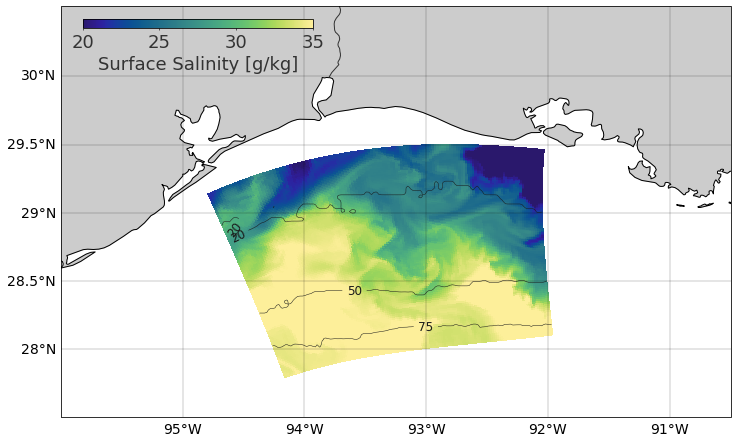

In [77]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], 
                  projection=ccrs.Mercator(central_longitude=-85.0))

depth = ds.isel(xi_rho = xislice,
                eta_rho = etaslice).h
hlevs = [20, 50, 75]  # isobath contour depths

mappable = ax.pcolormesh(lon[:].values, 
                         lat[:].values, 
                         salt[0,-1].values, 
                         cmap = cmo.haline, 
                         transform = cartopy.crs.PlateCarree(),
                         vmin = 20,
                         vmax = 35,
                        )

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-96, -90.5, 27.5, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, edgecolor='0.2')
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='0.2')
ax.set_aspect('auto')

cax = fig.add_axes([0.09, 0.91, 0.32, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Surface Salinity [g/kg]', fontsize=18, color='0.2')
cb.ax.tick_params(labelsize=18, length=2, color='0.2', labelcolor='0.2')

depths = ax.contour(lon[:].values, 
                    lat[:].values, 
                    depth, hlevs, 
                    colors='0.1', 
                    transform=ccrs.PlateCarree(), 
                    linewidths=0.5)
ax.clabel(depths, fmt = '%2.0f', fontsize = 12)
# ax.tick_params(axis='y', labelsize=18)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False


### Normalize the vertical relative vorticity by f. Note we have to get it on the u and v points first.

In [8]:
fx = grid.interp(ds.f, 'X', boundary = 'extend')
fxy = grid.interp(fx, 'Y', boundary = 'extend')
f = fxy.isel(eta_v = etaslice, xi_u = xislice)
 
RVn = (rv/f).isel(s_rho = -1)

/opt/miniconda3/envs/pong/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


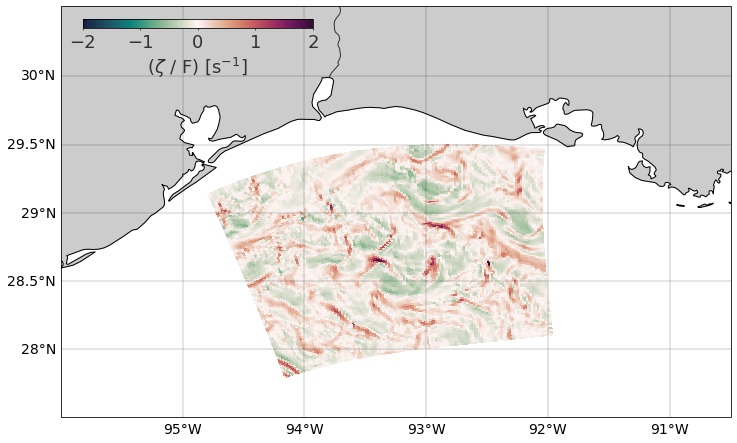

In [311]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], 
                  projection=ccrs.Mercator(central_longitude=-85.0))

depth = ds.isel(xi_rho = xislice,
                eta_rho = etaslice).h
hlevs = [20, 50, 75]  # isobath contour depths

mappable = ax.pcolormesh(lon[:].values, 
                         lat[:].values, 
                         RVn[0].values, 
                         cmap = cmo.curl, 
                         transform = cartopy.crs.PlateCarree(),
                         vmin = -2,
                         vmax = 2,
                        )

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-96, -90.5, 27.5, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, edgecolor='0.2')
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='0.2')
ax.set_aspect('auto')

cax = fig.add_axes([0.09, 0.91, 0.32, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'($\zeta$ / F) [s$^{-1}$]', fontsize=18, color='0.2')
cb.ax.tick_params(labelsize=18, length=2, color='0.2', labelcolor='0.2')

depths = ax.contour(lon[:].values, 
                    lat[:].values, 
                    colors='0.1', 
                    transform=ccrs.PlateCarree(), 
                    linewidths=0.5)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

/home/dylan/.conda/envs/copanoenv/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/dylan/.conda/envs/copanoenv/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


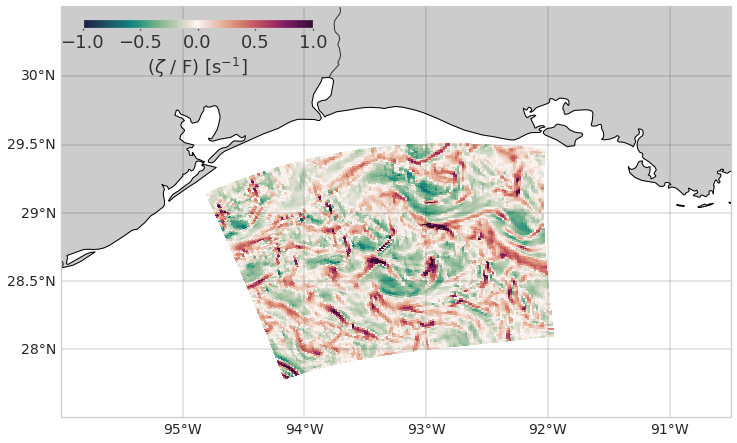

In [116]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], 
                  projection=ccrs.Mercator(central_longitude=-85.0))

depth = ds.isel(xi_rho = xislice,
                eta_rho = etaslice).h
hlevs = [20, 50, 75]  # isobath contour depths

mappable = ax.pcolormesh(lon[:].values, 
                         lat[:].values, 
                         RVn[0].values, 
                         cmap = cmo.curl, 
                         transform = cartopy.crs.PlateCarree(),
                         vmin = -1,
                         vmax = 1,
                        )

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-96, -90.5, 27.5, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, edgecolor='0.2')
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='0.2')
ax.set_aspect('auto')

cax = fig.add_axes([0.09, 0.91, 0.32, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'($\zeta$ / F) [s$^{-1}$]', fontsize=18, color='0.2')
cb.ax.tick_params(labelsize=18, length=2, color='0.2', labelcolor='0.2')

depths = ax.contour(lon[:].values, 
                    lat[:].values, 
                    colors='0.1', 
                    transform=ccrs.PlateCarree(), 
                    linewidths=0.5)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

### Compute histograms of $\zeta/f$ for the summer

In [9]:
zetabins = np.linspace(-3,3,50)

RVn.name = 'relative_vorticity_n'

RVn_slice = RVn.sel(ocean_time = slice('2009-06-15', '2009-07-25'))
zetaf_hist = histogram(RVn_slice[0:100], bins = [zetabins])

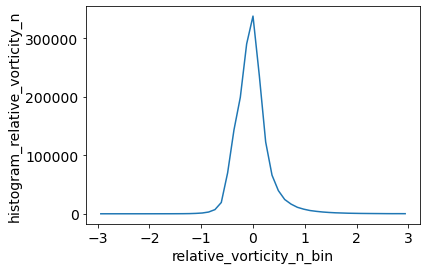

In [10]:
zetaf_hist.plot()

### Compute the surface salinity gradients. This will be part of the code for >salgrad.py

In [562]:
dsdx = ds.xroms.ddxi('salt')
dsdx_srho = grid.interp(dsdx, 'Z')
dsdx_rho = xroms.to_rho(dsdx_srho,grid)
dsdx = dsdx_rho.isel(eta_rho = etaslice, xi_rho = xislice, s_rho = -1)

dsdy = ds.xroms.ddeta('salt')
dsdy_srho = grid.interp(dsdy, 'Z')
dsdy_rho = xroms.to_rho(dsdy_srho,grid)
dsdy = dsdy_rho.isel(eta_rho = etaslice, xi_rho = xislice, s_rho = -1)

# dsdx = dsdx.isel(eta_rho = etaslice, xi_u = xislice, s_w = -2)
# dsdy = ds.xroms.ddeta('salt')
# dsdy = dsdy.isel(eta_v = etaslice, xi_rho = xislice, s_w = -2)

### Open the outputs of the vorticity histograms. Since we didn't assign a date to the histograms because we saved at every timestep we need to do a little manipulation. In retrospect I should have just assigned the time dimension apriori

In [8]:
path  = '/home/dylan/Variability/histograms/rho/histograms_zetaf_1994.nc'
test = xr.open_dataset(path)
bins = test.relative_vorticity_n_bin.values
bins

array([-2.47474747, -2.42424242, -2.37373737, -2.32323232, -2.27272727,
       -2.22222222, -2.17171717, -2.12121212, -2.07070707, -2.02020202,
       -1.96969697, -1.91919192, -1.86868687, -1.81818182, -1.76767677,
       -1.71717172, -1.66666667, -1.61616162, -1.56565657, -1.51515152,
       -1.46464646, -1.41414141, -1.36363636, -1.31313131, -1.26262626,
       -1.21212121, -1.16161616, -1.11111111, -1.06060606, -1.01010101,
       -0.95959596, -0.90909091, -0.85858586, -0.80808081, -0.75757576,
       -0.70707071, -0.65656566, -0.60606061, -0.55555556, -0.50505051,
       -0.45454545, -0.4040404 , -0.35353535, -0.3030303 , -0.25252525,
       -0.2020202 , -0.15151515, -0.1010101 , -0.05050505,  0.        ,
        0.05050505,  0.1010101 ,  0.15151515,  0.2020202 ,  0.25252525,
        0.3030303 ,  0.35353535,  0.4040404 ,  0.45454545,  0.50505051,
        0.55555556,  0.60606061,  0.65656566,  0.70707071,  0.75757576,
        0.80808081,  0.85858586,  0.90909091,  0.95959596,  1.01

In [7]:
years1 = np.arange(1994, 2017)
zetahists = []
times = []
for y in years1:
    paths = '/home/dylan/Variability/histograms/rho/histograms_zetaf_%i.nc' % y
    times.append(np.datetime64('%i' %y))
    zetahists.append(xr.open_dataset(paths).histogram_relative_vorticity_n.values)

times1 = np.array(times)
zetahists1 = np.array(zetahists)

zeta_da = xr.Dataset(data_vars = dict(
                     Rvort_histograms = (['times', 'vorticity_bins'], zetahists1)),
                     coords = dict(
                     times = times1,
                     vorticity_bins = bins)
                    )

zeta_da

<xarray.Dataset>
Dimensions:           (times: 23, vorticity_bins: 99)
Coordinates:
  * times             (times) datetime64[ns] 1994-01-01 ... 2016-01-01
  * vorticity_bins    (vorticity_bins) float64 -2.475 -2.424 ... 2.424 2.475
Data variables:
    Rvort_histograms  (times, vorticity_bins) float64 1.367e-05 ... 0.001004

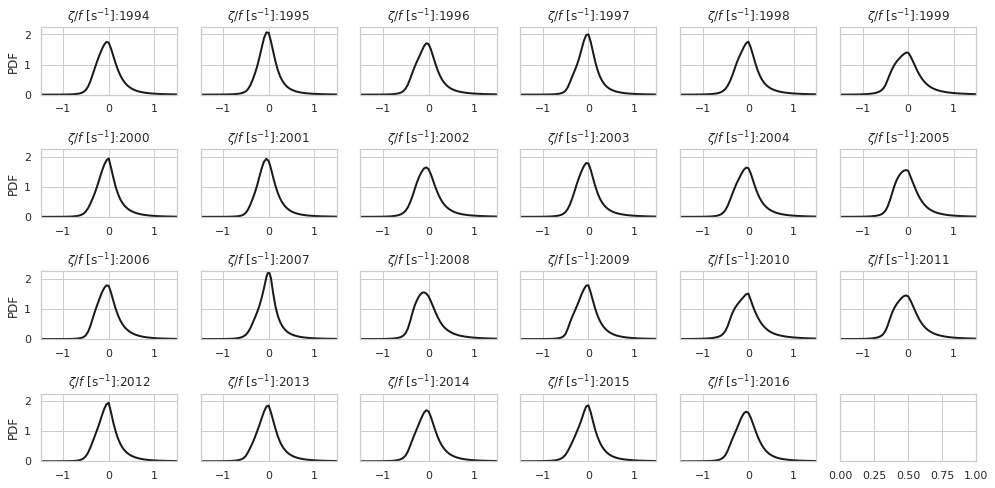

In [11]:
fig, ax = plt.subplots(4,6, figsize = (14, 7),sharey = True)

y = 0
for j in range(4):
    for i in range(6):
        y=y
        zeta_da.Rvort_histograms[y].plot(ax = ax[j,i],
                                         xlim = (-1.5,1.5),
                                         ylim = (0,2.25),
                                         color = 'k',
                                         lw = 2,
                                        )
        ax[j,i].set_ylabel('')
        ax[j,i].set_xlabel('')
        ax[j,i].set_title(r'$\zeta/f$ [s$^{-1}$]:'+str(1994+y))
        y+=1
        if y==23:
            break

        
for j in range(4):
    ax[j,0].set_ylabel('PDF')
    
fig.tight_layout()


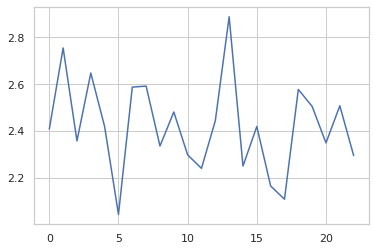

In [26]:
import scipy

zeta = zeta_da.Rvort_histograms.values

skewness = []
std = []
for i in range(len(zeta[:,0])):
    skewness.append(scipy.stats.skew(zeta[i,:]))

skewness = np.array(skewness)

plt.plot(skewness)

In [72]:
plt.rcParams.update({'font.size': 14})
# sns.reset_orig()

Text(0.5, 1.0, 'Relationship between $\\zeta/f$ and $\\partial_x s$: 1994-2016')

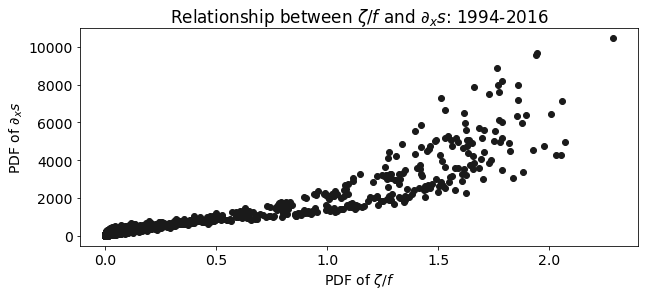

In [105]:
fig = plt.figure(figsize = (10,4))
plt.scatter(zeta_da.Rvort_histograms.values, dsdx_da.dsdx_histograms.values, color = 'k')
plt.xlabel(r'PDF of $\zeta/f$')a
plt.ylabel(r'PDF of $\partial_x s$')

plt.title('Relationship between $\zeta/f$ and $\partial_x s$: 1994-2016')

Text(0.5, 1.0, 'Relationship between $\\zeta/f$ and $\\partial_x s$: 1994-2016')

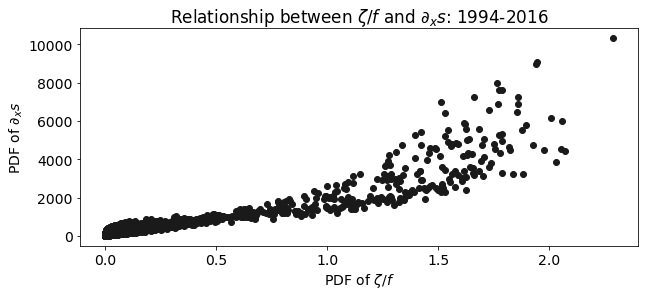

In [108]:
fig = plt.figure(figsize = (10,4))
plt.scatter(zeta_da.Rvort_histograms.values, dsdy_da.dsdy_histograms.values, color = 'k')
plt.xlabel(r'PDF of $\zeta/f$')
plt.ylabel(r'PDF of $\partial_x s$')

plt.title('Relationship between $\zeta/f$ and $\partial_x s$: 1994-2016')

In [100]:
np.shape(np.concatenate(zeta_da.Rvort_histograms.values))

(2277,)

In [101]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.concatenate(zeta_da.Rvort_histograms.values), np.concatenate(dsdx_da.dsdx_histograms.values),)
r_value

0.922301670094054

In [102]:
0.922**2

0.8500840000000001

In [75]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(zetastds, dsdxstds)
r_value

0.522400914965651

Text(0.5, 1.0, 'Standard Deviations of Vorticity and Salinity Gradient Histograms')

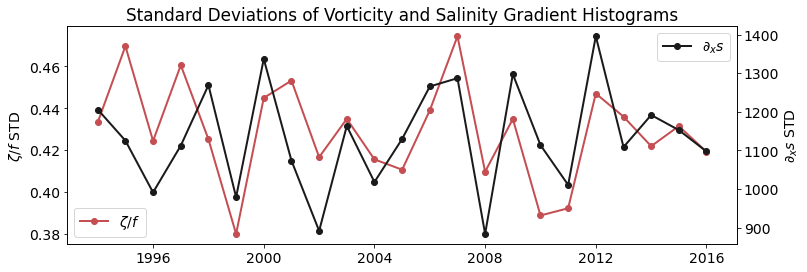

In [123]:
fig, ax1 = plt.subplots(figsize = (12,4))

ax1.plot(times,zetastds, marker = 'o', color = 'r', lw = 2, label = r'$\zeta/f$')
ax1.set_ylabel(r'$\zeta/f$ STD')
ax1.legend(loc = 3)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(times,dsdxstds, marker = 'o', color = 'k', lw = 2, label = r'$\partial_x s$')
ax2.set_ylabel(r'$\partial_x s$ STD')

ax2.legend()

plt.title('Standard Deviations of Vorticity and Salinity Gradient Histograms')

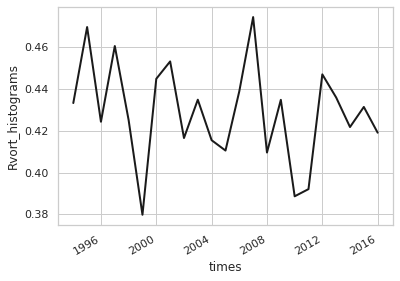

In [44]:
stds.plot(lw = 2, color = 'k')

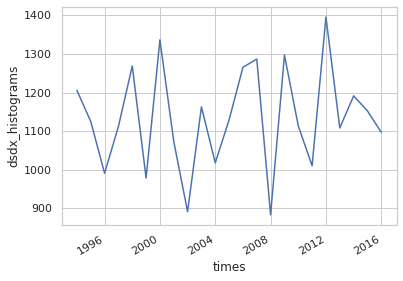

In [43]:
zetastds = zeta_da.Rvort_histograms.std(dim = 'vorticity_bins')
dsdxstds = dsdx_da.dsdx_histograms.std(dim = 'sgrad_bins')
dsdystds = dsdy_da.dsdy_histograms.std(dim = 'sgrad_bins')

# stds.plot(lw = 2, color = 'k')
dsdxstds.plot()

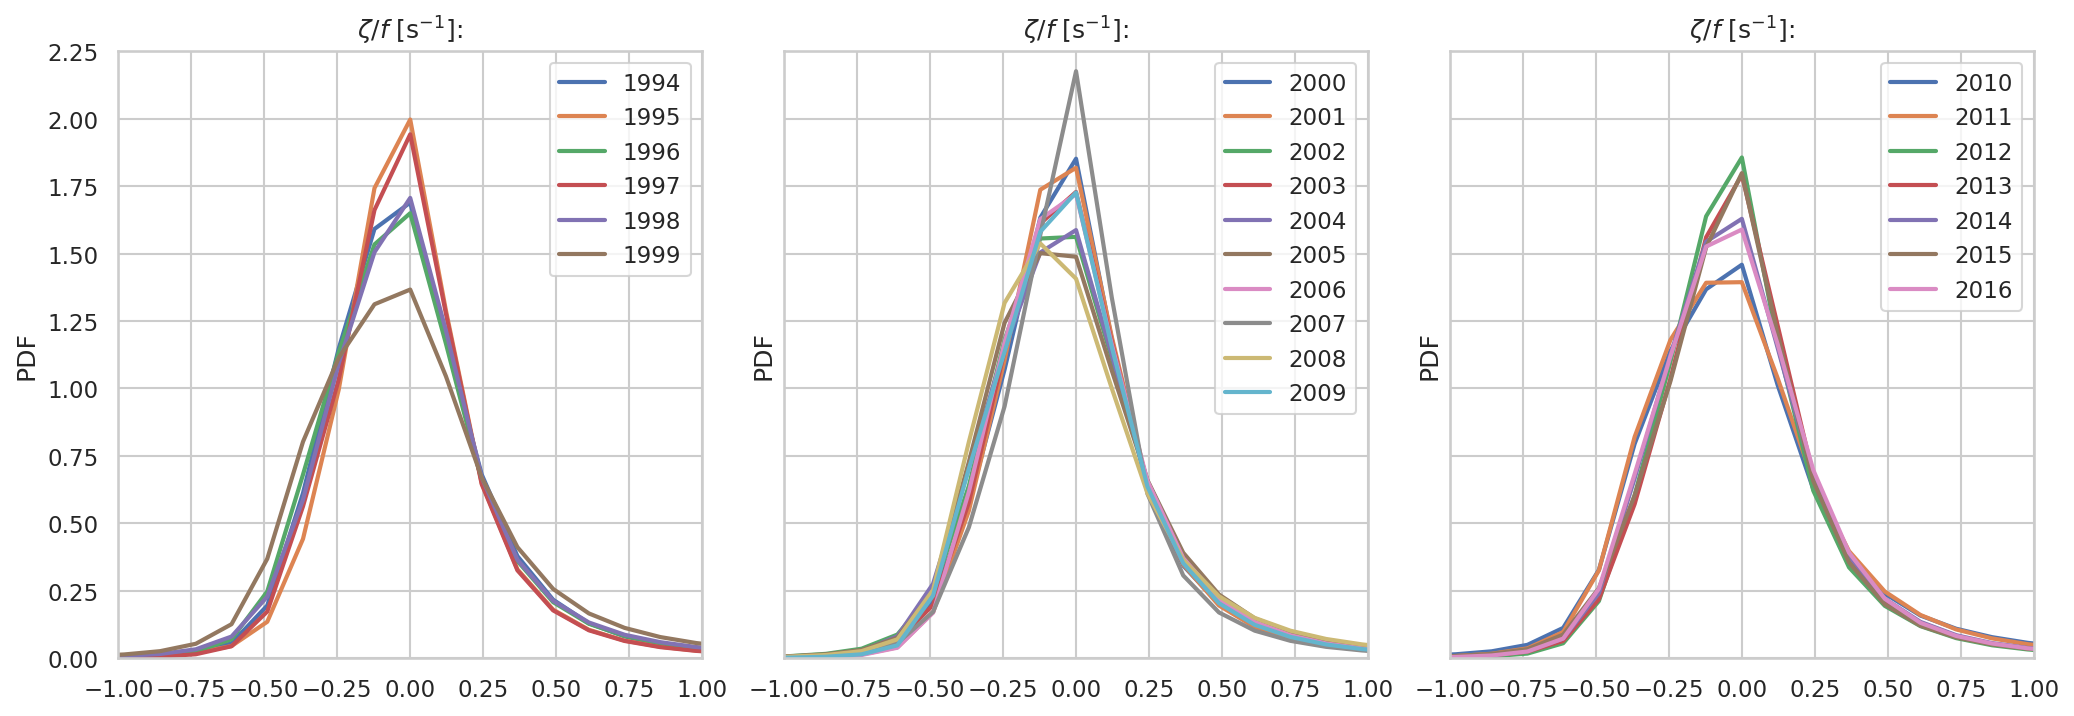

In [115]:
fig, ax = plt.subplots(1,3, figsize = (14, 5),sharey = True, dpi = 150)

for j in range(6):
        plots = zeta_da.Rvort_histograms[j].plot(ax = ax[0],
                                                 xlim = (-1.0,1.0),
                                                 ylim = (0,2.25),
                                                 lw = 2,
                                                 label = str(1994+j)
                                        )
        ax[0].set_ylabel('PDF')
        ax[0].set_xlabel('')
        ax[0].set_title(r'$\zeta/f$ [s$^{-1}$]:')
        ax[0].legend()

for j in range(10):
    plots = zeta_da.Rvort_histograms[j+6].plot(ax = ax[1],
                                             xlim = (-1.0,1.0),
                                             ylim = (0,2.25),
                                             lw = 2,
                                             label = str(1994+j+6)
                                )
    ax[1].set_ylabel('PDF')
    ax[1].set_xlabel('')
    ax[1].set_title(r'$\zeta/f$ [s$^{-1}$]:')
    ax[1].legend()
    
for j in range(7):
    plots = zeta_da.Rvort_histograms[j+6+10].plot(ax = ax[2],
                                               xlim = (-1.0,1.0),
                                               ylim = (0,2.25),
                                               lw = 2,
                                               label = str(1994+j+6+10)
                            )
    ax[2].set_ylabel('PDF')
    ax[2].set_xlabel('')
    ax[2].set_title(r'$\zeta/f$ [s$^{-1}$]:')
    ax[2].legend()
    
fig.tight_layout()

### Open the salinity gradient histograms. Repeat the same process as the vorticity

In [37]:
paths = '/home/dylan/Variability/histograms/dsdx/histograms_dsdx_1994.nc'
test = xr.open_dataset(paths)
sbins = test.dsdx_bin.values

In [38]:
years1 = np.arange(1994, 2017)
salhists = []
times = []
for y in years1:
    paths = '/home/dylan/Variability/histograms/dsdx/histograms_dsdx_%i.nc' % y
    times.append(np.datetime64('%i' %y))
    salhists.append(xr.open_dataset(paths).histogram_dsdx.values)

times1 = np.array(times)
salhists1 = np.array(salhists)

dsdx_da = xr.Dataset(data_vars = dict(
                     dsdx_histograms = (['times', 'sgrad_bins'], salhists1)),
                     coords = dict(
                     times = times1,
                     sgrad_bins = sbins)
                    )

salhists = []
times = []
for y in years1:
    paths = '/home/dylan/Variability/histograms/dsdy/histograms_dsdy_%i.nc' % y
    times.append(np.datetime64('%i' %y))
    salhists.append(xr.open_dataset(paths).histogram_dsdy.values)

salhists1 = np.array(salhists)

dsdy_da = xr.Dataset(data_vars = dict(
                     dsdy_histograms = (['times', 'sgrad_bins'], salhists1)),
                     coords = dict(
                     times = times1,
                     sgrad_bins = sbins)
                    )

In [27]:
dsdx_da

<xarray.Dataset>
Dimensions:          (sgrad_bins: 99, times: 23)
Coordinates:
  * times            (times) datetime64[ns] 1994-01-01 1995-01-01 ... 2016-01-01
  * sgrad_bins       (sgrad_bins) float64 -0.0009899 -0.0009697 ... 0.0009899
Data variables:
    dsdx_histograms  (times, sgrad_bins) float64 8.543 9.339 ... 8.97 8.042

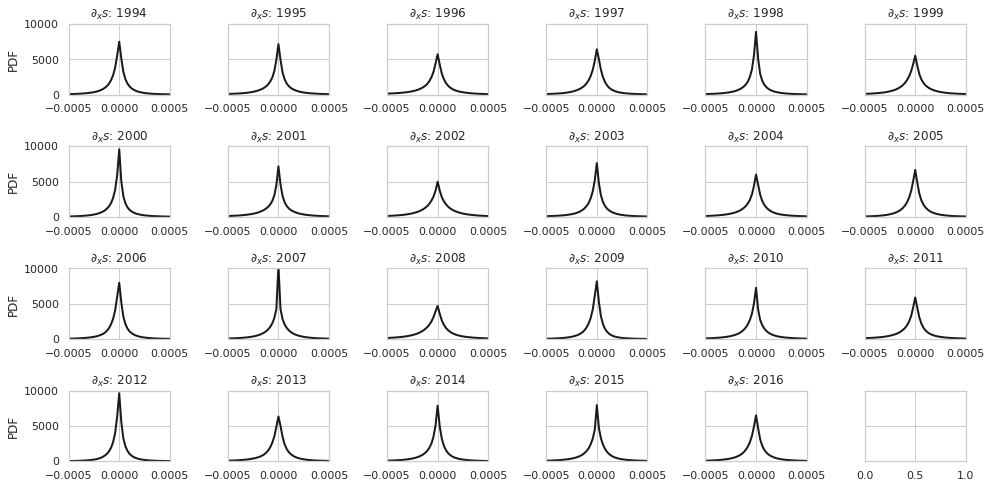

In [41]:
fig, ax = plt.subplots(4,6, figsize = (14, 7),sharey = True)

y = 0
for j in range(4):
    for i in range(6):
        y=y
        dsdx_da.dsdx_histograms[y].plot(ax = ax[j,i],
                                         xlim = (-0.0005,0.0005),
                                         ylim = (0,10000),
                                         color = 'k',
                                         lw = 2,
                                        )
        ax[j,i].set_ylabel('')
        ax[j,i].set_xlabel('')
        ax[j,i].set_title(r'$\partial_x s$: '+str(1994+y))
        y+=1
        if y==23:
            break

        
for j in range(4):
    ax[j,0].set_ylabel('PDF')
    
fig.tight_layout()


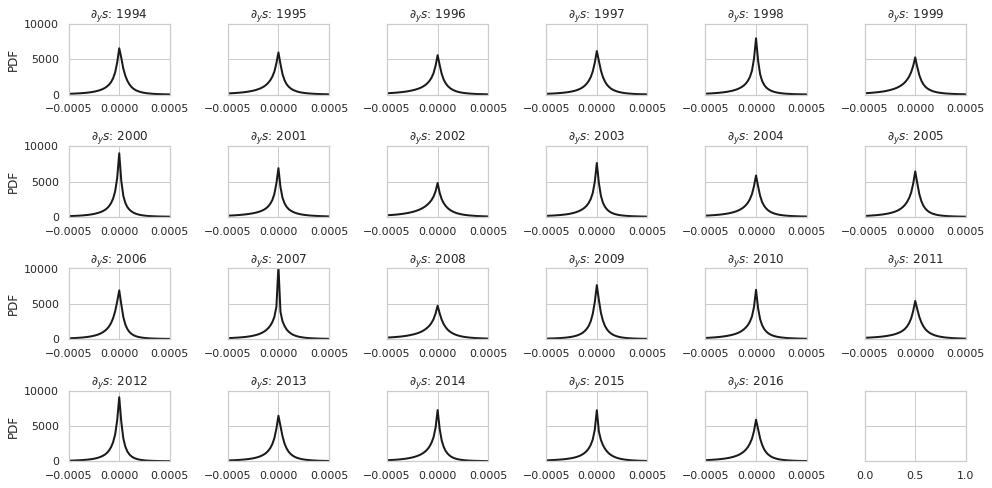

In [40]:
fig, ax = plt.subplots(4,6, figsize = (14, 7),sharey = True)

y = 0
for j in range(4):
    for i in range(6):
        y=y
        dsdy_da.dsdy_histograms[y].plot(ax = ax[j,i],
                                         xlim = (-0.0005,0.0005),
                                         ylim = (0,10000),
                                         color = 'k',
                                         lw = 2,
                                        )
        ax[j,i].set_ylabel('')
        ax[j,i].set_xlabel('')
        ax[j,i].set_title(r'$\partial_y s $: '+str(1994+y))
        y+=1
        if y==23:
            break

        
for j in range(4):
    ax[j,0].set_ylabel('PDF')
    
fig.tight_layout()

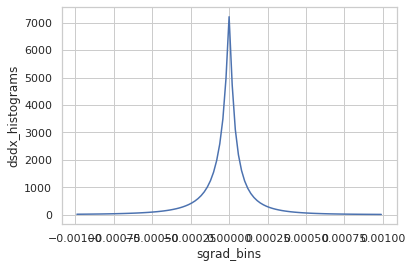

In [51]:
dsdx_da.dsdx_histograms.mean(dim = 'times').plot()

In [ ]:
years1 = np.arange(1994, 2017)
zetahists = []
times = []
for y in years1:
    paths = '/home/dylan/Variability/histograms/rho/histograms_zetaf_%i.nc' % y
    times.append(np.datetime64('%i' %y))
    zetahists.append(xr.open_dataset(paths).histogram_relative_vorticity_n.values)

times1 = np.array(times)
zetahists1 = np.array(zetahists)

bins = zetahists1

zeta_da = xr.Dataset(data_vars = dict(
                     Rvort_histograms = (['times', 'vorticity_bins'], zetahists1)),
                     coords = dict(
                     times = times1,
                     vorticity_bins = bins)
                    )

zeta_da


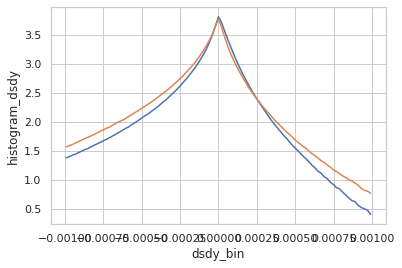

In [15]:
dsdy = xr.open_mfdataset('/home/dylan/Variability/histograms/dsdy/histograms_dsdy_1994.nc')
dsdy1 = xr.open_mfdataset('/home/dylan/Variability/histograms/dsdy/histograms_dsdy_1995.nc')
# dsdy = xr.open_mfdataset('/home/dylan/Variability/histograms/dsdy/histograms_dsdy_1994.nc')

np.log10(dsdy.histogram_dsdy).plot()
np.log10(dsdy1.histogram_dsdy).plot()
# np.log10(dsdy.histogram_dsdy).plot()

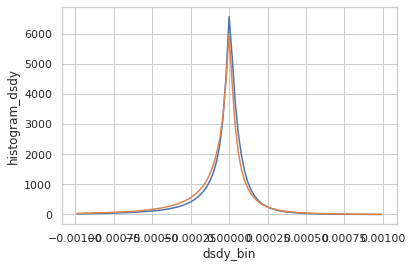

In [14]:
dsdy.histogram_dsdy.plot()
dsdy1.histogram_dsdy.plot()

In [57]:
test = pd.bdate_range(start = '1994', end = '2017', freq = 'Y')
years = pd.DatetimeIndex(test).year

In [71]:
df = pd.DataFrame(zetahists1.T, columns = [years])
# df.index = bins
df.set_index['times']

TypeError: 'method' object is not subscriptable